## Feature Engineering

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('NFLplays2017.csv')
dfcopy = df.copy()

In [3]:
# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
np.set_printoptions(suppress=True)

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, f1_score, fbeta_score, roc_curve

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [4]:
# Keep only relevant columns, rename as necessary

cols = ['PASS', 'game_date', 'game_id', 'posteam','defteam','drive','play_id', 
        'yardline_100', 'down', 'ydstogo',
        'half_seconds_remaining', 'game_seconds_remaining', 'game_half',
        'shotgun', 'score_differential']

df = df[cols]
df = df.rename(columns ={'score_differential':'points_ahead', 'ydstogo':'distance',
                         'half_seconds_remaining':'half_secs_remain',
                         'game_seconds_remaining':'game_secs_remain',
                         'yardline_100':'totyardstogo'})

In [5]:
# Convert 'game_half' column to numeric and drop 177 'Overtime' data points

# Half1       15917
# Half2       15790
# Overtime      177

df = df.drop(df[df['game_half'] == 'Overtime'].index).reset_index(drop=True)
df['second_half'] = df['game_half'].apply(lambda x: 1 if x == 'Half2' else 0)
df['second_half'].value_counts()

0    15917
1    15790
Name: second_half, dtype: int64

In [9]:
# More feature engineering

df['firstdown'] = df['down'].apply(lambda x: 1 if x == 1 else 0)
df['seconddown'] = df['down'].apply(lambda x: 1 if x == 2 else 0)
df['thirddown'] = df['down'].apply(lambda x: 1 if x == 3 else 0)
df['fourthdown'] = df['down'].apply(lambda x: 1 if x == 4 else 0)

df['FGrange'] = df['totyardstogo'].apply(lambda x: 1 if x <= 35 else 0)

mask  = (df['down'] == 3) & (df['distance'] >= 5)
df['thirdandlong'] = 0
df.loc[mask, 'thirdandlong'] = 1

mask  = (df['down'] == 4) & (df['distance'] >= 5)
df['fourthandlong'] = 0
df.loc[mask, 'fourthandlong'] = 1
df.sample(20)

,PASS,game_date,game_id,posteam,defteam,drive,play_id,totyardstogo,down,distance,...,shotgun,points_ahead,second_half,firstdown,seconddown,thirddown,fourthdown,FGrange,thirdandlong,fourthandlong
18295,0,2017-11-19,2017111900,CHI,DET,16,2780,76.0,3.0,2,...,1,-3.0,1,0,0,1,0,0,0,0
12558,1,2017-10-22,2017102210,LAC,DEN,11,1590,62.0,1.0,10,...,0,13.0,0,1,0,0,0,0,0,0
12842,1,2017-10-22,2017102211,NYG,SEA,21,3502,81.0,3.0,8,...,1,-10.0,1,0,0,1,0,0,1,0
15708,1,2017-11-05,2017110506,BAL,TEN,22,3691,29.0,2.0,5,...,1,-10.0,1,0,1,0,0,1,0,0
25576,1,2017-12-10,2017121013,PIT,BAL,22,4437,64.0,2.0,4,...,1,-2.0,1,0,1,0,0,0,0,0
1564,0,2017-09-10,2017091012,DAL,NYG,18,3515,21.0,2.0,14,...,0,13.0,1,0,1,0,0,1,0,0
5064,0,2017-09-24,2017092407,NE,HOU,8,999,42.0,1.0,10,...,0,-3.0,0,1,0,0,0,0,0,0
18078,1,2017-11-13,2017111300,CAR,MIA,18,3440,32.0,3.0,8,...,1,24.0,1,0,0,1,0,1,1,0
3084,1,2017-09-17,2017091708,LAC,MIA,5,870,23.0,3.0,4,...,1,-3.0,0,0,0,1,0,1,0,0
17897,0,2017-11-12,2017111211,NE,DEN,10,1758,66.0,2.0,1,...,0,11.0,0,0,1,0,0,0,0,0


In [10]:
#list of columns to be used as features

featcols = ['totyardstogo', 'FGrange', 'down', 'distance', 
        'half_secs_remain', 'game_secs_remain', 'second_half',
        'shotgun', 'points_ahead', 'firstdown','seconddown', 
        'thirddown','fourthdown', 'thirdandlong','fourthandlong']

# Target: 1 is a pass play, 0 is a run play.

display(df.PASS.value_counts())
print('Pass percentage:', 19153/(19153+12554))  # 0.604

1    19153
0    12554
Name: PASS, dtype: int64

Pass percentage: 0.6040621944680985


In [128]:
df.to_csv('NFLplays2017final.csv',index=False)

## Logistic Model

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df[featcols], df['PASS'], 
                                                    test_size = 0.2, random_state=42)


X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, 
                                                    test_size = 0.2, random_state=42)

pd.to_csv()
# sns.pairplot(train_df.sample(1000), hue='PASS');
# sns.scatterplot(x=X_train['down'],y= X_train['distance'], hue=['PASS']);

In [25]:
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)
X_tr_scaled = std_scale.fit_transform(X_tr)

X_test_scaled = std_scale.transform(X_test)
X_val_scaled = std_scale.transform(X_val)

logreg_cv = LogisticRegression(solver = 'liblinear', penalty = 'l1')
param_grid = {'C': [0.1, 1, 10, 100, 1000]}

grid_logreg = GridSearchCV(logreg_cv, param_grid, cv=5, scoring='accuracy')
grid_logreg.fit(X_tr_scaled, y_tr)

df_cv = pd.DataFrame(grid_logreg.cv_results_)
display(df_cv[['param_C','mean_test_score','std_test_score','rank_test_score']]
        .sort_values(by='mean_test_score'))

print("Best params: ", grid_logreg.best_params_)
print("Best estimator: ", grid_logreg.best_estimator_)
print("Best score: ", grid_logreg.best_score_)


,param_C,mean_test_score,std_test_score,rank_test_score
2,10,0.739306,0.004369,3
3,100,0.739306,0.004369,3
4,1000,0.739306,0.004369,3
1,1,0.739405,0.004558,2
0,0.1,0.739503,0.004280,1


Best params:  {'C': 0.1}
Best estimator:  LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
Best score:  0.7395034988478832


Baseline accuracy:   0.6040621944680985
Train accuracy:   0.6904198698994678
Val accuracy:   0.6849990143899074
Train confusion matrix: 

 [[6226 1853]
 [4429 7784]] 

Test confusion matrix: 

 [[1513  439]
 [1159 1962]]
              precision    recall  f1-score   support

         Run       0.57      0.78      0.65      1952
        Pass       0.82      0.63      0.71      3121

    accuracy                           0.68      5073
   macro avg       0.69      0.70      0.68      5073
weighted avg       0.72      0.68      0.69      5073



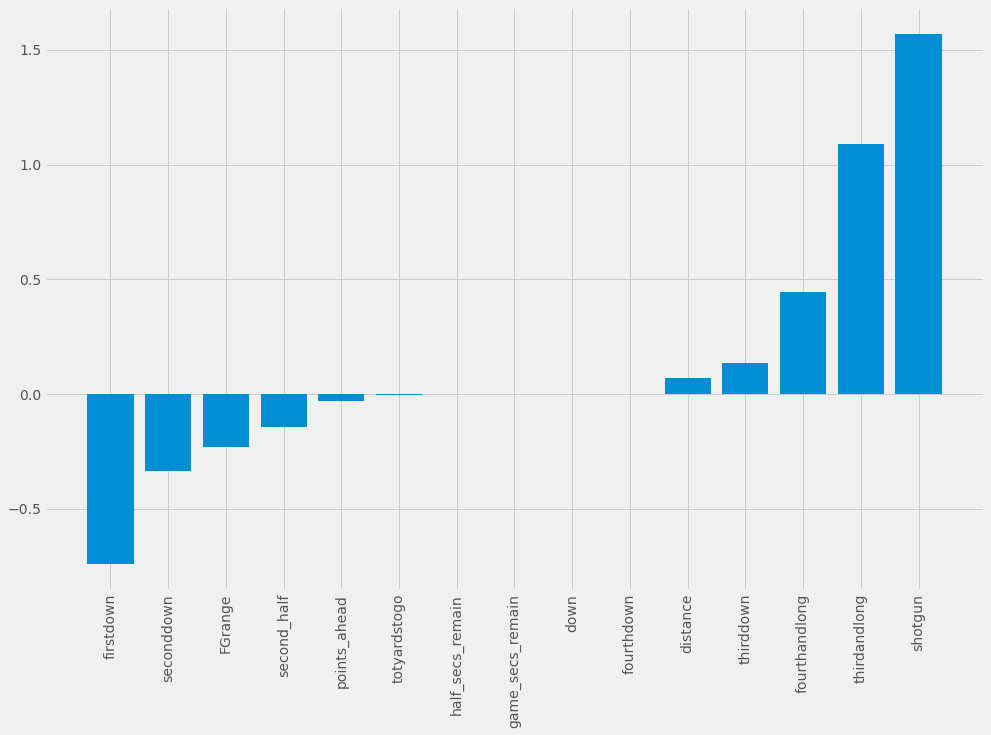

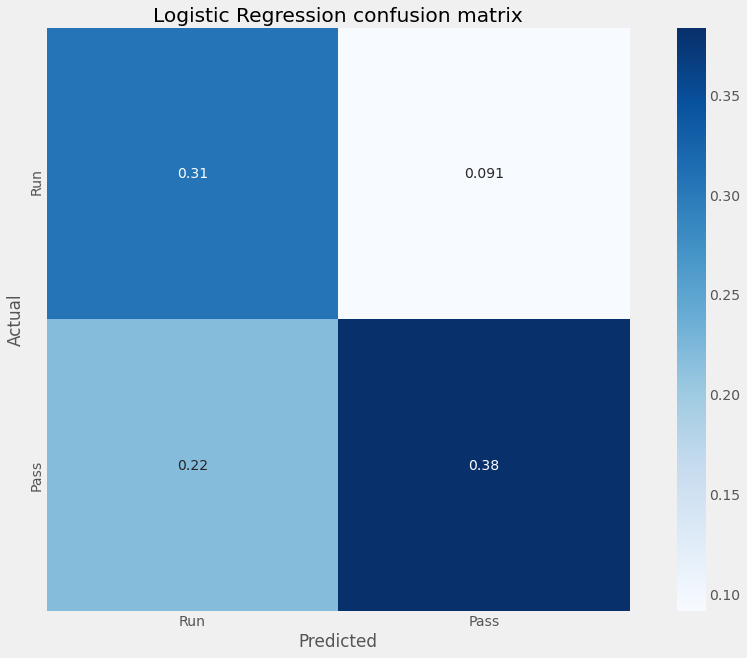

In [62]:
logreg = LogisticRegression(solver = 'liblinear', penalty = 'l1', C = 0.1, 
                            class_weight = None, 
                            random_state=42)
logreg.fit(X_tr, y_tr)

D = dict(zip(X_tr.columns, logreg.coef_.T.flatten()))
D = {k: v for k, v in sorted(D.items(), key=lambda item: item[1])}

plt.figure(figsize=(15, 10))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.xticks(rotation=90);

print("Baseline accuracy:  ",  19153/(19153+12554))
print("Train accuracy:  ", logreg.score(X_tr_scaled, y_tr))
print("Val accuracy:  ", logreg.score(X_val_scaled, y_val))

from sklearn.metrics import confusion_matrix

print("Train confusion matrix: \n\n", confusion_matrix(y_tr, logreg.predict(X_tr_scaled)),'\n')
print("Test confusion matrix: \n\n", confusion_matrix(y_val, logreg.predict(X_val_scaled),))

plt.figure(figsize=(15, 10))
train_confusion = confusion_matrix(y_tr, logreg.predict(X_tr_scaled), normalize='all')
sns.heatmap(train_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['Run', 'Pass'],
           yticklabels=['Run', 'Pass'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression confusion matrix');



from sklearn.metrics import classification_report
print(classification_report(y_val, logreg.predict(X_val_scaled), target_names=['Run', 'Pass']))



## KNN Model

0.7325054208555095
Baseline accuracy:   0.6040621944680985
Train accuracy:   0.7497043169722057
Val accuracy:   0.7325054208555095
Train confusion matrix: 

 [[5580 2499]
 [2580 9633]] 

Test confusion matrix: 

 [[1317  635]
 [ 722 2399]]
              precision    recall  f1-score   support

         Run       0.65      0.67      0.66      1952
        Pass       0.79      0.77      0.78      3121

    accuracy                           0.73      5073
   macro avg       0.72      0.72      0.72      5073
weighted avg       0.73      0.73      0.73      5073



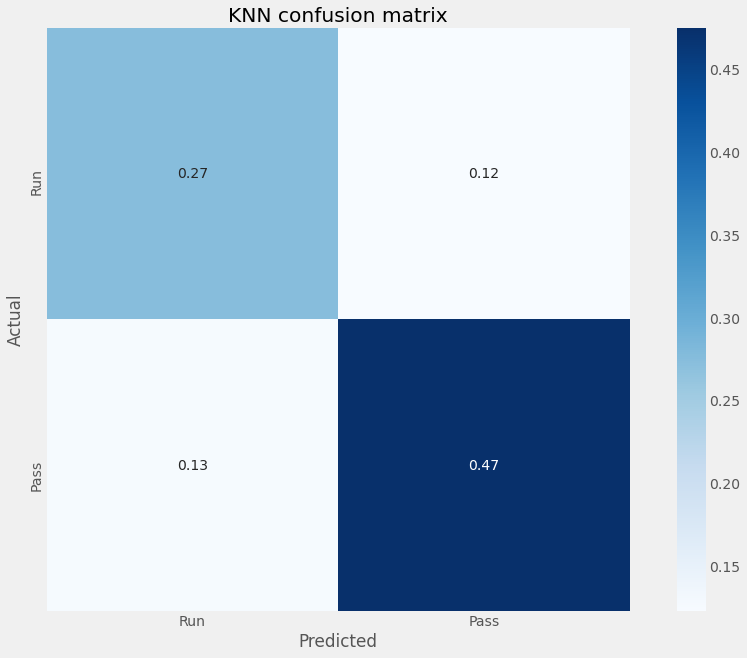

In [125]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=40)
knn.fit(X_tr_scaled, y_tr)
y_pred = knn.predict(X_val_scaled)

print(accuracy_score(y_val, y_pred))

print("Baseline accuracy:  ",  19153/(19153+12554))
print("Train accuracy:  ", knn.score(X_tr_scaled, y_tr))
print("Val accuracy:  ", knn.score(X_val_scaled, y_val))

from sklearn.metrics import confusion_matrix

print("Train confusion matrix: \n\n", confusion_matrix(y_tr, knn.predict(X_tr_scaled)),'\n')
print("Test confusion matrix: \n\n", confusion_matrix(y_val, knn.predict(X_val_scaled),))

plt.figure(figsize=(15, 10))
train_confusion = confusion_matrix(y_tr, knn.predict(X_tr_scaled), normalize='all')
sns.heatmap(train_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['Run', 'Pass'],
           yticklabels=['Run', 'Pass'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN confusion matrix');


from sklearn.metrics import classification_report
print(classification_report(y_val, knn.predict(X_val_scaled), target_names=['Run', 'Pass']))



## Decision Tree Model

0.7396513185078981
Baseline accuracy:   0.6040621944680985
Train accuracy:   0.7396510940272029
Val accuracy:   0.7368421052631579
Train confusion matrix: 

 [[5573 2506]
 [2777 9436]] 

Test confusion matrix: 

 [[1350  602]
 [ 733 2388]]
              precision    recall  f1-score   support

         Run       0.65      0.69      0.67      1952
        Pass       0.80      0.77      0.78      3121

    accuracy                           0.74      5073
   macro avg       0.72      0.73      0.73      5073
weighted avg       0.74      0.74      0.74      5073



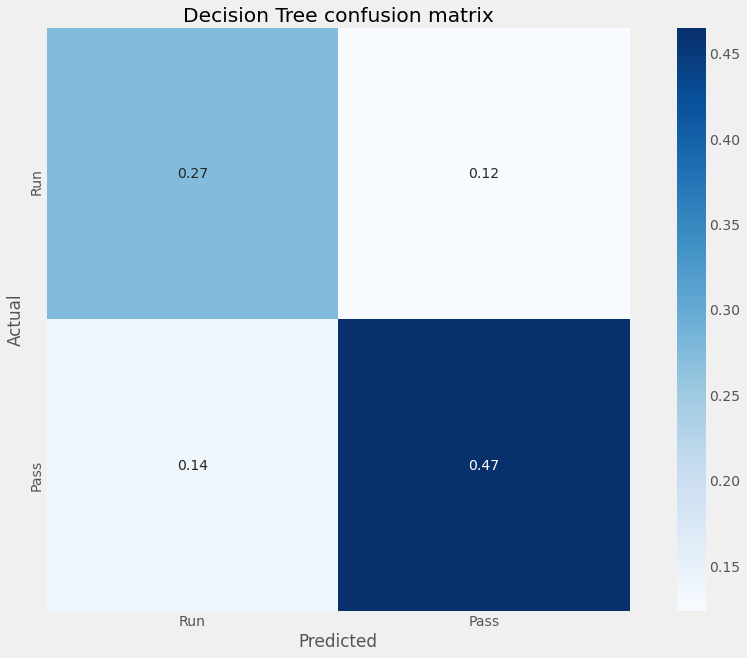

In [140]:
dectree = DecisionTreeClassifier(max_depth = 1, random_state=42, criterion = "gini")
scores = cross_val_score(dectree, X_tr, y_tr, cv=5, scoring='accuracy')
print(scores.mean())

dectree.fit(X_tr, y_tr)

print("Baseline accuracy:  ",  19153/(19153+12554))
print("Train accuracy:  ", dectree.score(X_tr, y_tr))
print("Val accuracy:  ", dectree.score(X_val, y_val))


print("Train confusion matrix: \n\n", confusion_matrix(y_tr, dectree.predict(X_tr)),'\n')
print("Test confusion matrix: \n\n", confusion_matrix(y_val, dectree.predict(X_val),))

plt.figure(figsize=(15, 10))
train_confusion = confusion_matrix(y_tr, dectree.predict(X_tr), normalize='all')
sns.heatmap(train_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['Run', 'Pass'],
           yticklabels=['Run', 'Pass'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree confusion matrix');

from sklearn.metrics import classification_report
print(classification_report(y_val, dectree.predict(X_val), target_names=['Run', 'Pass']))

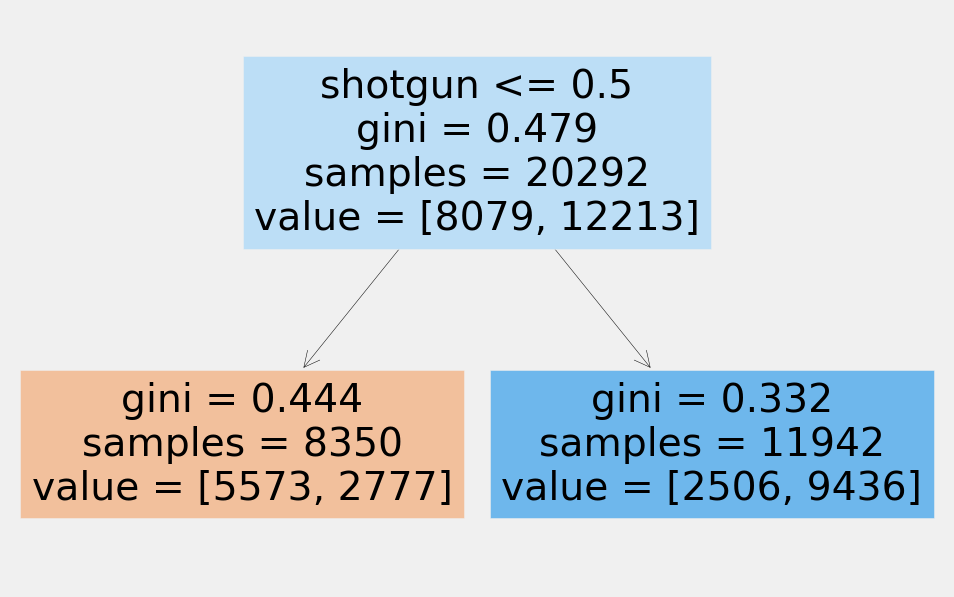

In [141]:
from sklearn import tree

# text_representation = tree.export_text(dectree)
# print(text_representation)

fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(dectree, 
                   feature_names=X_train.columns,  
#                    class_names=['Pass', 'Run'],
                   filled=True)

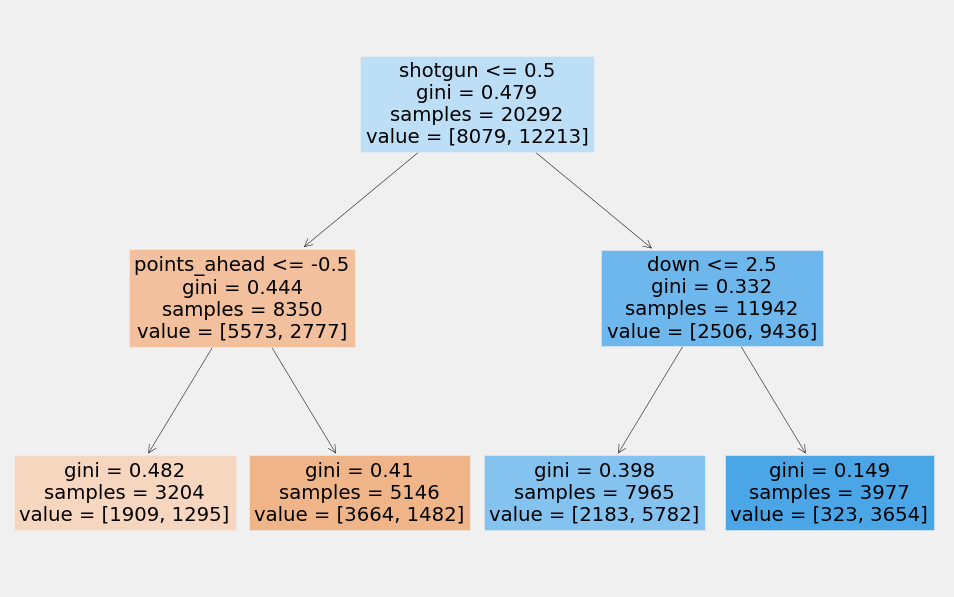

## Random Forest Model

In [93]:
forest = RandomForestClassifier(n_estimators = 100, max_features=3, max_depth=4, random_state=42)
scores = cross_val_score(forest, X_train, y_train, cv=5, scoring='accuracy')
print(scores.mean())

forest.fit(X_train, y_train)

0.7405874236152178


RandomForestClassifier(max_depth=4, max_features=3, random_state=42)

In [ ]:
forest_grid = RandomForestClassifier(n_estimators =100, random_state=42)
param_grid = {'max_depth': [3,4,5,6],
              'max_features': [3,5,7,9]
              }

grid = GridSearchCV(forest_grid, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

df_cv = pd.DataFrame(grid.cv_results_)

In [95]:
display(df_cv[['param_max_depth','param_max_features','mean_test_score','std_test_score','rank_test_score']]
        .sort_values(by='mean_test_score'))

print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

,param_max_depth,param_max_features,mean_test_score,std_test_score,rank_test_score
0,3,3,0.738419,0.005700,16
3,3,9,0.739996,0.005332,15
7,4,9,0.740193,0.005367,14
2,3,7,0.740272,0.005331,13
1,3,5,0.740311,0.005280,11
6,4,7,0.740311,0.005274,11
5,4,5,0.740548,0.005328,10
4,4,3,0.740587,0.005368,9
9,5,5,0.740627,0.005439,8
8,5,3,0.740785,0.005628,6


Best params:  {'max_depth': 6, 'max_features': 9}
Best estimator:  RandomForestClassifier(max_depth=6, max_features=9, random_state=42)
Best score:  0.7428740390301597


0.7412280701754386
0.739404691504041
F1 Score: 0.7842689295039164 

Train confusion matrix: 

 [[5559 2520]
 [2731 9482]] 

Test confusion matrix: 

 [[1348  604]
 [ 718 2403]]
              precision    recall  f1-score   support

         Run       0.65      0.69      0.67      1952
        Pass       0.80      0.77      0.78      3121

    accuracy                           0.74      5073
   macro avg       0.73      0.73      0.73      5073
weighted avg       0.74      0.74      0.74      5073



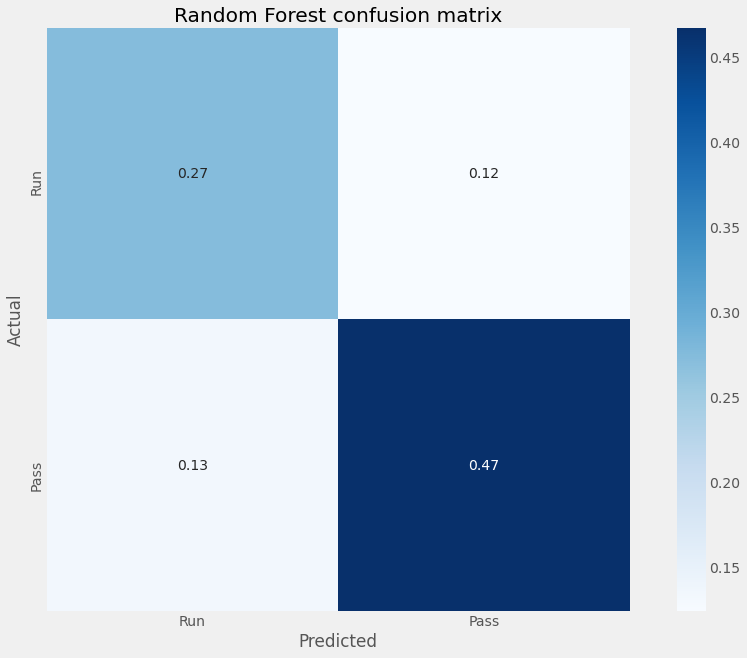

In [108]:
forest = RandomForestClassifier(n_estimators = 100, max_features = 5, max_depth = 4, 
                                random_state=42, class_weight=None)
forest.fit(X_tr, y_tr)
print(forest.score(X_tr, y_tr))
print(forest.score(X_val, y_val))
preds = forest.predict(X_val) 
print('F1 Score:', f1_score(preds, y_val), '\n')


print("Train confusion matrix: \n\n", confusion_matrix(y_tr, forest.predict(X_tr)),'\n')
print("Test confusion matrix: \n\n", confusion_matrix(y_val, forest.predict(X_val),))

plt.figure(figsize=(15, 10))
train_confusion = confusion_matrix(y_tr, forest.predict(X_tr), normalize='all')
sns.heatmap(train_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['Run', 'Pass'],
           yticklabels=['Run', 'Pass'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest confusion matrix');


from sklearn.metrics import classification_report
print(classification_report(y_val, forest.predict(X_val), target_names=['Run', 'Pass']))



Text(0, 0.5, 'Mean decrease in impurity')

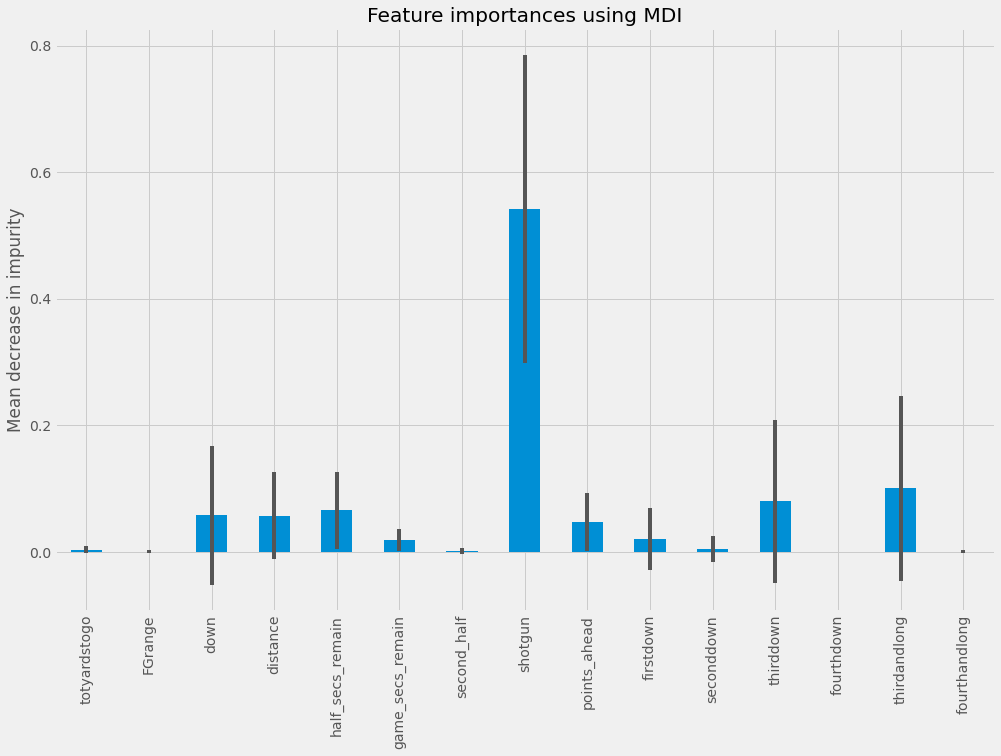

In [138]:
importances = forest.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(15, 10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

Elapsed time to compute the importances: 3.889 seconds


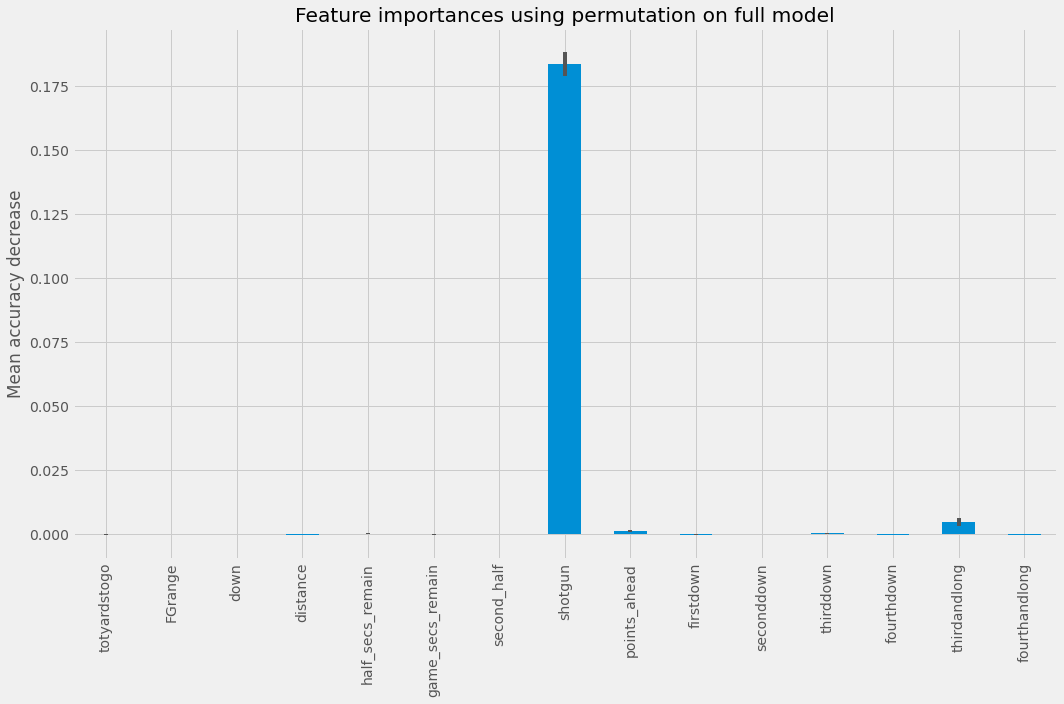

In [139]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=X_train.columns)

fig, ax = plt.subplots(figsize=(15, 10))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()